In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys, os
sys.path.append('../')
from galaxybrain import ramsey, ising

import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
import pandas as pd
import time
from IPython.display import clear_output

# Starting from scratch
using [this](https://www.asc.ohio-state.edu/braaten.1/statphys/Ising_MatLab.pdf)<br>
Hamiltonian – rate of change in time of the condition of a dynamic physical system, or total energy in the system – is given by

\\[ H = -J\sum_{ij} s_is_j \\] 

Summing interactions between [4] neighbors, J (Strength of interaction in Joules) is usually 1 <br>
"In the case of an Ising system, instead of moving a particle, we switch the direction of its spin."

In each monte carlo sweep:
- "Propose" a move: (done in aggregate for each particle)
    - if ∆E < 0  (i.e., the move would bring the system to a state of lower energy; this is desired in physical systems), accept it
    - if ∆E > 0, accept move with probability exp(-∆E/kT) where k is Joules per kelvin.

let's try to do this vectorized

Furnstahl:  multiply every transition probability by 0.1 to avoid undesirable oscillatory regimes

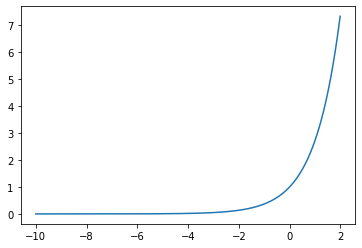

In [5]:
x  = np.arange(-10,2,0.01)
plt.plot(x,np.exp(x),'-')

In [4]:
mouse1 = ising.metro_ising(N=650,T=2.26918531421, plot=False,runtime=1000)
mouse1_slice = pd.DataFrame(mouse1[200:][:,325])

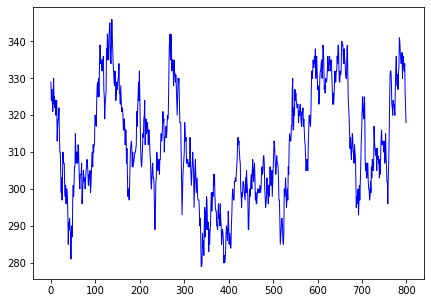

In [8]:
plt.figure(figsize=(7,5)); plt.plot(np.sum(mouse1_slice.T),'blue',lw='1')

/Users/brianbarry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':


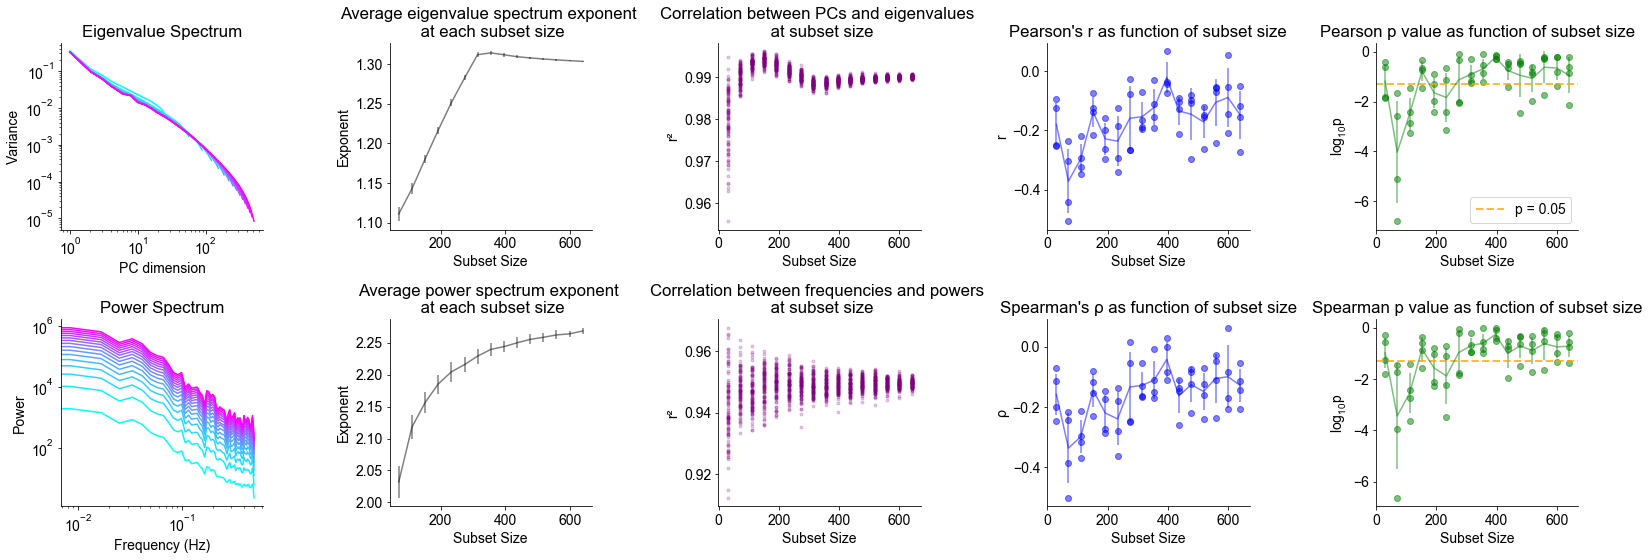

In [78]:
mouse1 = metropolis_ising(N=650,T=2.26918531421, plot=False,runtime=1000)
mouse1_slice = pd.DataFrame(mouse1[200:][:,325])
subsetsizes = np.linspace(30,640,16, dtype=int)
n_iters = 95; n_pc = 0.8; f_range = [0,0.4]; pc_range = [0,0.7]
decomp_arr = []
for i in range(4):
    eigs, pows, pca_m, s_r2, ft_m, t_r2, psn_r, spn_r, psn_p, spn_p = ramsey.ramsey(mouse1_slice.T, subsetsizes, n_iters = 95, n_pc = 0.8, f_range = [0,0.4], verbose = False)
    decomp_arr.append([pca_m, ft_m, psn_r, spn_r, psn_p, spn_p])
decomp_arr = np.array(decomp_arr)
ramsey.plot_all_measures(subsetsizes, s_r2, t_r2, n_iters, n_pc, f_range, pc_range, eigs, pows,decomp_arr[:,0].mean(0), decomp_arr[:,1].mean(0), decomp_arr[:,2], decomp_arr[:,3], decomp_arr[:,4], decomp_arr[:,5])

/Users/brianbarry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


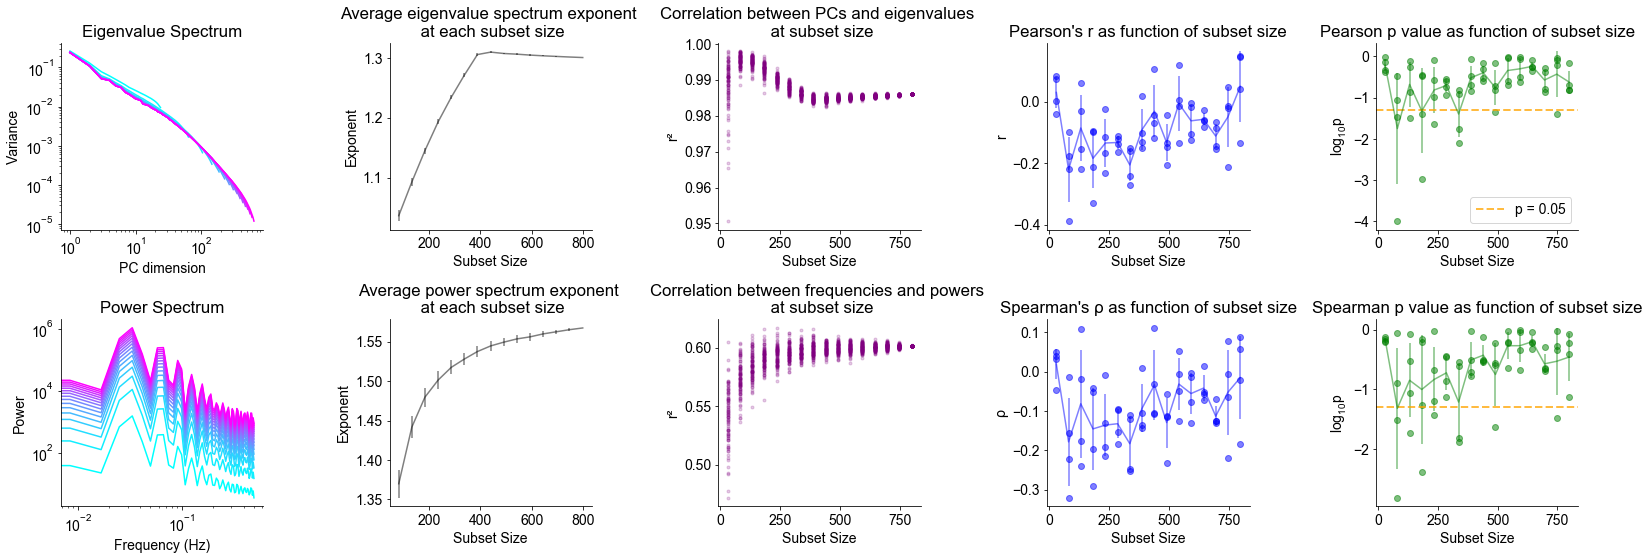

In [34]:
mouse1 = metropolis_ising(N=32,T=2.26918531421, plot=False,runtime=1000) # NOTE: this was using flattened frames
subsetsizes = np.linspace(30,799,16, dtype=int)
n_iters = 95; n_pc = 0.8; f_range = [0,0.4]; pc_range = [0,None]
decomp_arr = []
for i in range(4):
    eigs, pows, pca_m, s_r2, ft_m, t_r2, psn_r, spn_r, psn_p, spn_p = ramsey.ramsey(mouse1[200:].T, subsetsizes, n_iters = 95, n_pc = 0.8, f_range = [0,0.4], verbose = False)
    decomp_arr.append([pca_m, ft_m, psn_r, spn_r, psn_p, spn_p])
decomp_arr = np.array(decomp_arr)
ramsey.plot_all_measures(subsetsizes, s_r2, t_r2, n_iters, n_pc, f_range, pc_range, eigs, pows,decomp_arr[:,0].mean(0), decomp_arr[:,1].mean(0), decomp_arr[:,2], decomp_arr[:,3], decomp_arr[:,4], decomp_arr[:,5])

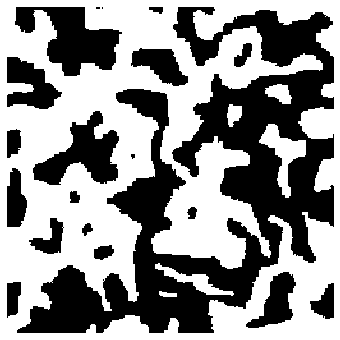

In [7]:
x= ising.metro_ising(N=256,T=0.1,runtime=500,plot='static')

## A Network Simulation: Ising model ripped from https://rajeshrinet.github.io/blog/2014/ising-model/

"2D Ising model: For two and higher dimensions, we can introduce islands of defects, which cost only at the boundaries, and are thus, proportional to the perimeter  L=εN2 , where  0<ε<1 . In 2D, the number of islands scale as  3εN2 , while  ΔE=ε4JN2 .  ΔF  is then  ε4JN2−kBTln(N23εN2) . This gives a rough estimate of the critical temperature  Tc∼J/kB."

So we need to think about the shape of our current data.  If it is 1d, then we might not see spontaneous symmetry breaking. 

My additions:
- An init method
- A raster return from the simulate function.
    - The ising frame is flattened at and appended to the raster at each time point
- A video mode in simulate function (gimmicky)

In [5]:
class Ising():
    ''' Simulating the Ising model '''    
    
    def __init__(self, size = 64, temp=.4, run_time = 1001, speed = .01):
        self.size = size
        self.temp = temp
        self.run_time = run_time
        self.speed = speed #video speed; kind of maxes out at .01 but is slowed down by plotting and computation
        
    ## monte carlo moves    
    def mcmove(self, config, N, beta):
        ''' This is to execute the monte carlo moves using 
        Metropolis algorithm such that detailed
        balance condition is satisified'''
        for i in range(N):
            for j in range(N):            
                    a = np.random.randint(0, N)
                    b = np.random.randint(0, N)
                    s =  config[a, b]
                    nb = config[(a+1)%N,b] + config[a,(b+1)%N] + config[(a-1)%N,b] + config[a,(b-1)%N] #+ \
                    #config[(a+1)%N,(b+1)%N] + config[(a-1)%N,(b-1)%N] + config[(a+1)%N,(b-1)%N] + config[(a-1)%N,(b+1)%N] 
                    cost = 2*s*nb
                    if cost < 0:
                        s *= -1
                    elif rand() < np.exp(-cost*beta):
                        s *= -1
                    config[a, b] = s
        return config
    
    def simulate(self, frame_mode = False, video_mode = False):   
        ''' This module simulates the Ising model'''
        N, temp = self.size, self.temp # Initialse the lattice
        config = 2*np.random.randint(2, size=(N,N))-1 #start with white noise lattice
        f = plt.figure(figsize=(15, 15), dpi=80);    
        
        msrmnt = self.run_time
        raster = []
        for i in range(msrmnt):
            config = self.mcmove(config, N, 1.0/temp)
            raster.append(config.flatten())
            if frame_mode == True:
                if i == 0:
                    self.configPlot(f, config, 0, N, 1);
                elif i == 1:       
                    self.configPlot(f, config, i, N, 2);
                elif i == int(.004*msrmnt):       
                    self.configPlot(f, config, i, N, 3);
                elif i == int(.032*msrmnt):      
                    self.configPlot(f, config, i, N, 4);
                elif i == int(.1*msrmnt):     
                    self.configPlot(f, config, i, N, 5);
                elif i == msrmnt -1:    
                    self.configPlot(f, config, i, N, 6);
                    
            elif video_mode == True:
                plt.figure()
                self.configPlot(f, config, i, N, 1)
                plt.show()
                time.sleep(self.speed)
                clear_output(wait=True)
            
        plt.show() 
        
        raster_df = pd.DataFrame(data = np.array(raster))
        raster_df[raster_df==-1]=0
        return raster_df

    def configPlot(self, f, config, i, N, n_ = None, subplots = True):
        ''' This modules plts the configuration once passed to it along with time etc '''
        X, Y = np.meshgrid(range(N), range(N))
        if subplots == True:
            sp =  f.add_subplot(3, 3, n_ )  
            plt.setp(sp.get_yticklabels(), visible=False)
            plt.setp(sp.get_xticklabels(), visible=False)      
        plt.pcolormesh(X, Y, config, cmap='gray');
        plt.title('Time=%d'%i); plt.axis('tight')    
    #plt.show()

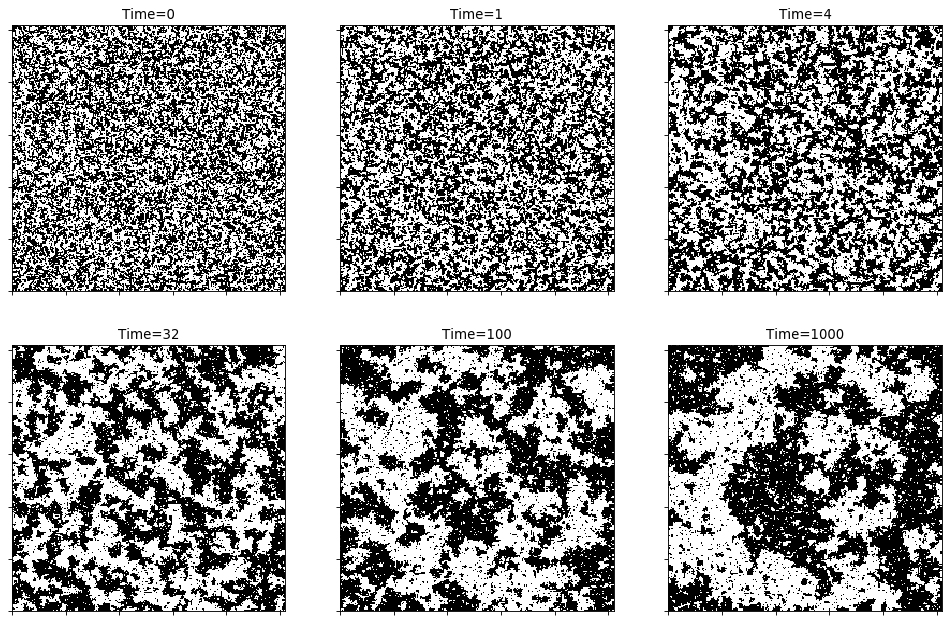

In [6]:
rm = Ising(size = 256, temp = 2.26918531421)
test = rm.simulate(frame_mode = True)

In [79]:
test

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1,1,0,0,0,0,0,1,1,1,...,1,1,0,0,0,0,1,1,1,1
1,0,0,0,0,0,0,0,1,1,1,...,1,1,0,0,0,0,1,1,1,1
2,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,1,1,1,1,1,1
3,0,0,0,0,0,0,1,1,1,1,...,0,0,0,0,0,1,1,1,1,1
4,0,0,0,0,0,0,1,1,1,1,...,0,0,0,0,0,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,1,0,0,0,0,0,1,1,1,1,...,1,0,0,0,0,0,1,1,1,1
997,1,0,0,0,0,0,1,1,1,1,...,1,0,0,0,0,0,1,1,1,1
998,1,0,0,0,0,0,1,1,1,1,...,1,0,0,0,0,0,1,1,1,1
999,1,0,0,0,0,0,1,1,1,1,...,1,0,0,0,0,0,1,1,1,1


# Running Ramsey Analysis on the Ising raster!

What is the minimum temperature for it to work?  And what does that minimum temperature mean?

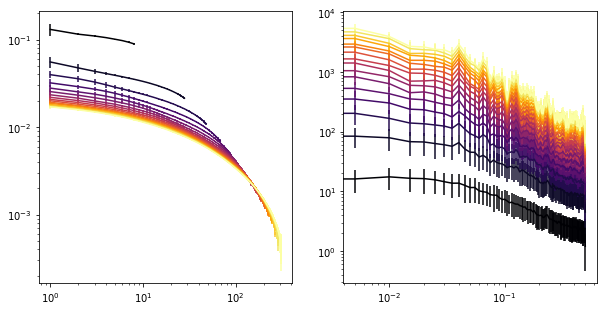

In [5]:
# T = 3

subsetsizes = np.arange (10,400,25)
eigs, pows, pca_m, s_r2, ft_m, t_r2, psn_r, spn_r, psn_p, spn_p = ramsey.ramsey(test, subsetsizes, n_pc = 0.8, f_range = [0,0.4])

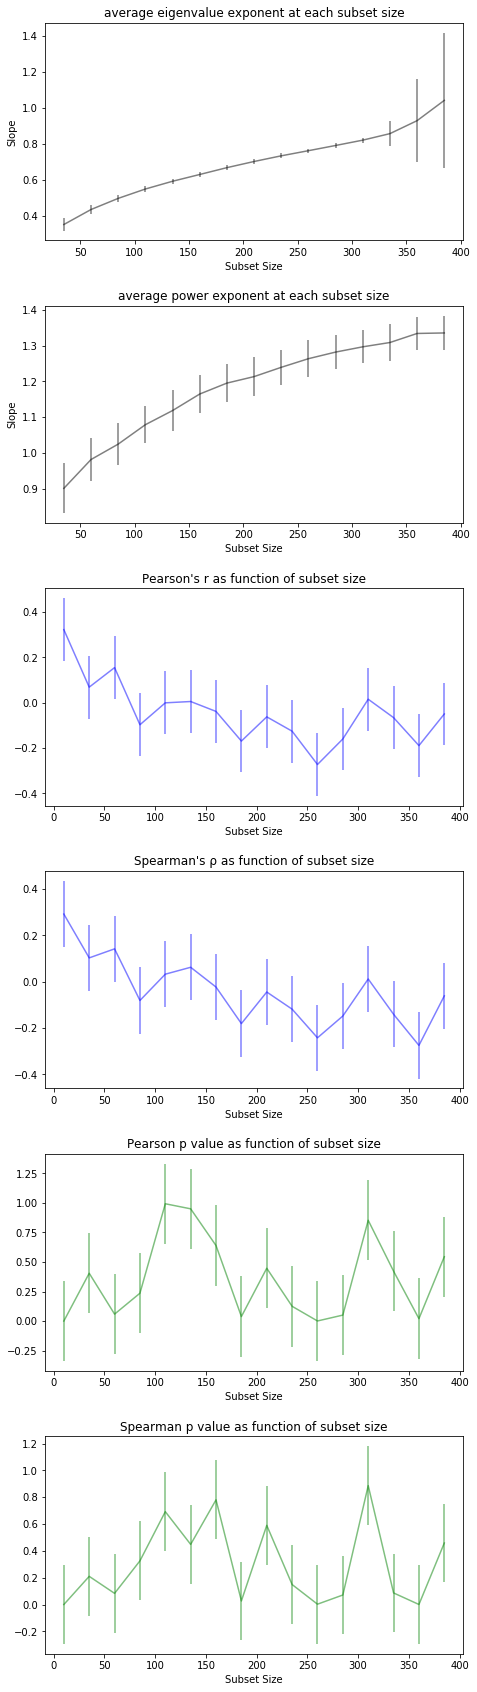

In [94]:
ramsey.plot_decomp_features(subsetsizes, pca_m, ft_m, psn_r, spn_r, psn_p, spn_p)

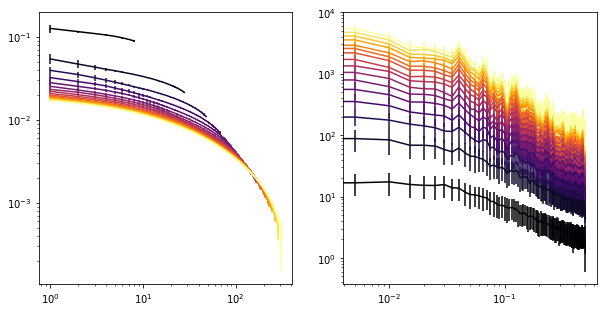

In [4]:
#T = 3.5
subsetsizes = np.arange (10,400,25)
eigs, pows, pca_m, s_r2, ft_m, t_r2, psn_r, spn_r, psn_p, spn_p = ramsey.ramsey(test, subsetsizes, n_pc = 0.8, f_range = [0,0.4])

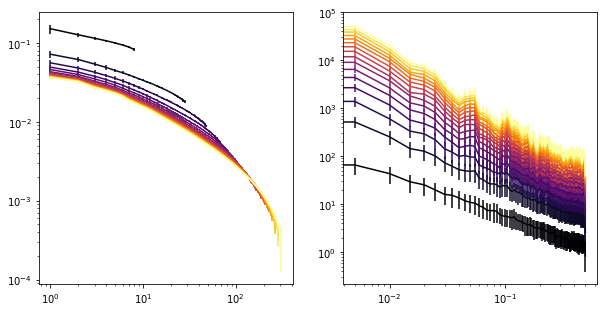

In [7]:
#T = 2.7
subsetsizes = np.arange (10,400,25)
eigs, pows, pca_m, s_r2, ft_m, t_r2, psn_r, spn_r, psn_p, spn_p = ramsey.ramsey(test, subsetsizes, n_pc = 0.8, f_range = [0,0.4])

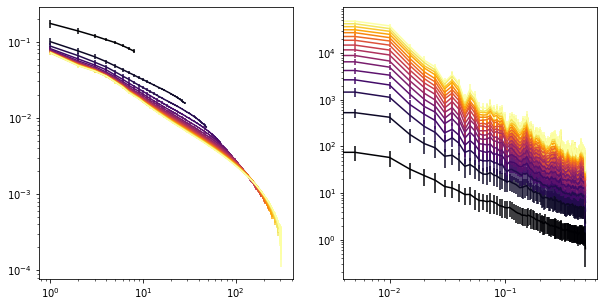

In [11]:
#T= 2.5 
subsetsizes = np.arange (10,400,25)
eigs, pows, pca_m, s_r2, ft_m, t_r2, psn_r, spn_r, psn_p, spn_p = ramsey.ramsey(test, subsetsizes, n_pc = 0.8, f_range = [0,0.4])

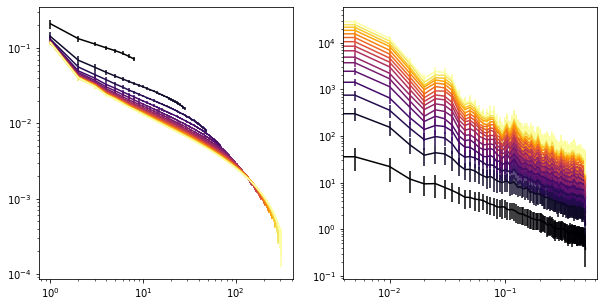

In [9]:
#T= 2.25 
subsetsizes = np.arange (10,400,25)
eigs, pows, pca_m, s_r2, ft_m, t_r2, psn_r, spn_r, psn_p, spn_p = ramsey.ramsey(test, subsetsizes, n_pc = 0.8, f_range = [0,0.4])

### Now at the so called critical temperature according to ising.js (though going out on a limb here)

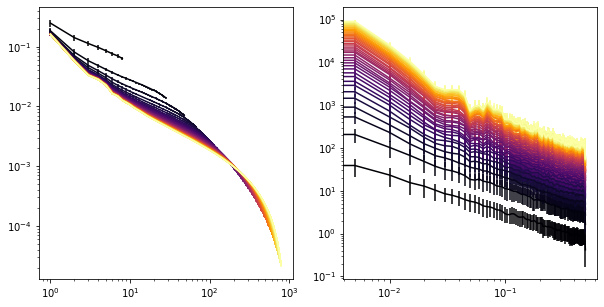

In [6]:
#T= 2.26918531421
subsetsizes = np.arange (10,1000,25)
eigs, pows, pca_m, s_r2, ft_m, t_r2, psn_r, spn_r, psn_p, spn_p = ramsey.ramsey(test, subsetsizes, n_pc = 0.8, f_range = [0,0.4])

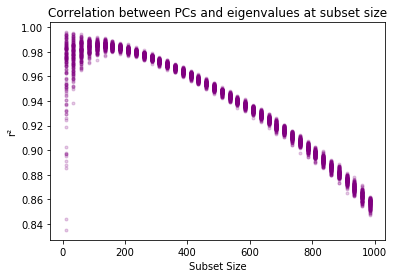

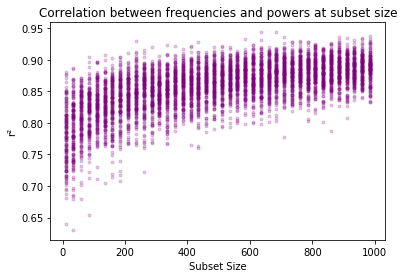

In [8]:
ramsey.plot_comp_spectra_corr(subsetsizes,s_r2, t_r2)

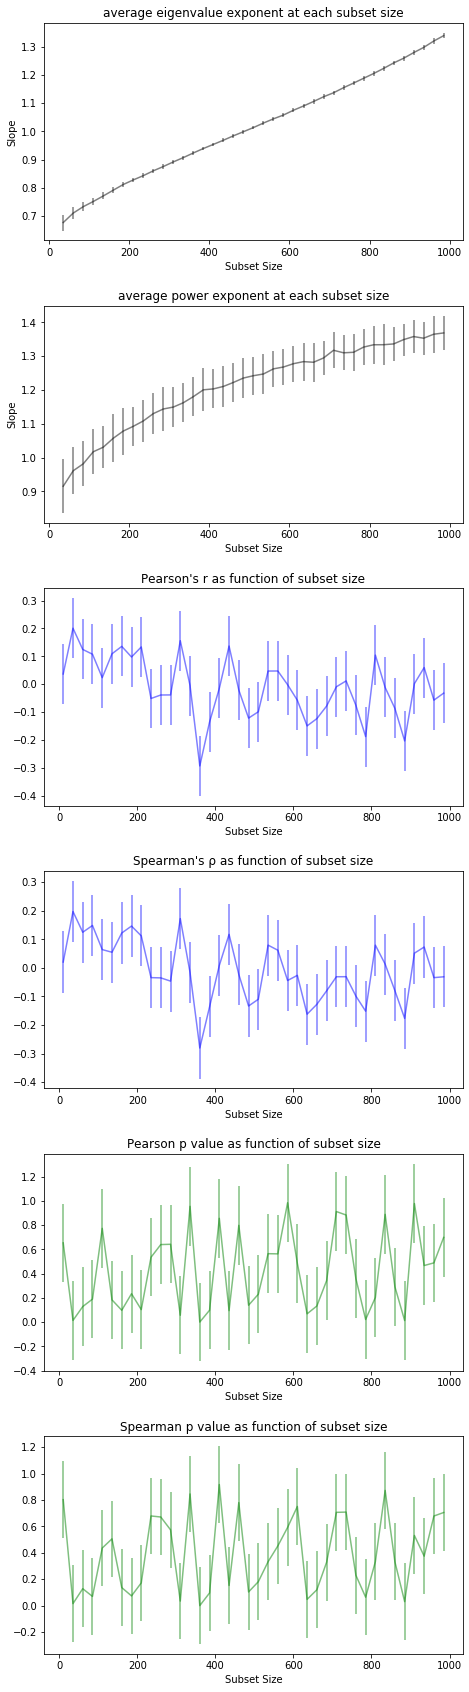

In [7]:
ramsey.plot_decomp_features(subsetsizes, pca_m, ft_m, psn_r, spn_r, psn_p, spn_p)